# Title: Predicting Risk of Heart Disease Using Classification #
Group 14:
Jackie Hagstrom,
Hannah Reyes,
Mikayla Ditosto,
Minal Nijhawan 

# Introduction #
According to the Ohio Department of Health, heart disease resulted in the death of more than 26,000 residents in 2016, with Ohio being the 13th state with the highest rate of deaths due to heart disease (Heart Disease, 2016). Considering the relevance of heart disease in Ohio, as a group, we decided that we will conduct an analysis on heart disease data in Cleveland, Ohio, in order to determine which variables allow us to best predict heart disease in a patient (Heart Disease, 2016). 

We are utilizing a data set from the UC Irvine Machine Learning Repository. This directory encompasses information concerning heart disease diagnosis from four distinct databases: Cleveland Clinic Foundation, Hungarian Institute of Cardiology (Budapest), University Hospital, Zurich (Switzerland), and V.A. Medical Center, Long Beach (CA). Our analysis will be performed on the Cleveland data set. This data set classifies the presence of heart disease in a patient on a scale of 0-4 (0 implying the absence of risk and 4 indicating the greatest presence). Specifically, a value of 0 indicates < 50% diameter narrowing, and value 1 is > 50% diameter narrowing in any major vessel.
Through this project, we are trying to answer the question: What variables can be used to classify a person’s risk of heart disease in Cleveland?

We will answer this question using a machine-learning algorithm called K-nearest neighbors.  The response variable, num, is categorical so we will be solving this as a classification problem. This model relies on categorized input data to predict the category of new unlabeled data. K-NN functions by finding the straight-line distance in a plot between unlabeled data and all examples in the training data, selecting the “K” nearest neighbors closest to the unlabelled data, then voting for the most frequent label of those neighbors. We will tune the model using cross-validation to determine which K value produces the highest predictive accuracy on the training data, then carry that over to the testing data.

There are 14 different variables provided in the data set that can help detect the risk of heart disease in a patient. However, we will not utilize all 14 variables to build our classification model. Throughout our exploratory data analysis, we will provide reasoning for the variables we decided not to include.
Please see the bottom of this document for the variable meanings.


# Preliminary exploratory data analysis #

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.6     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
# dataset was read into R
set.seed(2023)
cleveland_data <- read_csv("https://raw.githubusercontent.com/mikayladitosto/dsci-100-2023s1-group-14/main/processed.cleveland.data", col_names = FALSE)
colnames(cleveland_data) <- c("age",
                              "sex",
                              "cp",
                              "trestbps",
                              "chol",
                              "fbs",
                              "restecg",
                              "thalach",
                              "exang",
                              "oldpeak",
                              "slope",
                              "ca",
                              "thal",
                              "num")

# changed data types of columns to be able to perform classification and EDA
cleveland_data <- cleveland_data |>
    mutate(num = as_factor(num),
           ca = as.numeric(ca),
           thal = as.numeric(thal))

# removed N/A ("?") values from the dataset
cleveland_data <- cleveland_data |>
    filter(age != "?",
           sex != "?",
           cp != "?",
           trestbps != "?",
           chol != "?",
           fbs != "?",
           restecg != "?",
           thalach != "?",
           exang != "?",
           oldpeak != "?",
           slope != "?",
           ca != "?",
           thal != "?"
          )

head(cleveland_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `ca = as.numeric(ca)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0


We downloaded the Cleveland data set and uploaded it to GitHub through our shared repository. After this step, we copied the URL into R, and we were able to read it with the read_csv function. Demonstrating that the dataset can be read from the web into R. 

In [3]:
# split the data into training and testing splits
cleveland_split <- initial_split(cleveland_data, prop = 0.75, strata = num)
cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

In [4]:
num_obs <- nrow(cleveland_training)
cleveland_training |>
  group_by(num) |>
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )

num,count,percentage
<fct>,<int>,<dbl>
0,120,54.298643
1,40,18.099548
2,26,11.764706
3,26,11.764706
4,9,4.072398


This table shows us the number of observations in each category of heart disease. There is not an equal amount of people in each category, meaning our graphs can look disproportionate. During the classification analysis, we will make the classes proportionate by using class balancing to ensure the rarer classes are equally represented.

In [5]:
cleveland_mean <- cleveland_training |>
    group_by(num) |>
    summarise(mean_age = mean(age),
              mean_sex = mean(sex),
              mean_cp = mean(cp),
              mean_trestbps = mean(trestbps),
              mean_chol = mean(chol),
              mean_fbs = mean(fbs),
              mean_restecg = mean(restecg),
              mean_thalach = mean(thalach),
              mean_exang = mean(exang),
              mean_oldpeak = mean(oldpeak),
              mean_slope = mean(slope),
              mean_ca = mean(ca),
              mean_thal = mean(thal))
cleveland_mean

cleveland_sd <- cleveland_training |>
    group_by(num) |>
    summarise(sd_age = sd(age),
              sd_sex = sd(sex),
              sd_cp = sd(cp),
              sd_trestbps = sd(trestbps),
              sd_chol = sd(chol),
              sd_fbs = sd(fbs),
              sd_restecg = sd(restecg),
              sd_thalach = sd(thalach),
              sd_exang = sd(exang),
              sd_oldpeak = sd(oldpeak),
              sd_slope = sd(slope),
              sd_ca = sd(ca),
              sd_thal = sd(thal))
cleveland_sd

num,mean_age,mean_sex,mean_cp,mean_trestbps,mean_chol,mean_fbs,mean_restecg,mean_thalach,mean_exang,mean_oldpeak,mean_slope,mean_ca,mean_thal
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,52.44167,0.5083333,2.775000,129.3417,244.1917,0.1416667,0.8583333,158.8250,0.1666667,0.5966667,1.375000,0.2833333,3.675000
1,55.07500,0.8500000,3.275000,132.7250,247.9000,0.0500000,1.0500000,146.4000,0.4500000,1.0200000,1.650000,0.6250000,5.375000
2,58.07692,0.7307692,3.730769,135.8462,276.4231,0.2307692,0.8846154,131.6154,0.5384615,1.9000000,1.961538,1.3076923,5.961538
3,55.69231,0.7692308,3.846154,134.1154,248.7308,0.2307692,1.4230769,133.1538,0.6153846,2.1230769,1.961538,1.5000000,6.192308
4,58.66667,0.8888889,3.666667,139.8889,273.4444,0.1111111,1.4444444,143.5556,0.5555556,2.4000000,2.111111,1.6666667,6.444444


num,sd_age,sd_sex,sd_cp,sd_trestbps,sd_chol,sd_fbs,sd_restecg,sd_thalach,sd_exang,sd_oldpeak,sd_slope,sd_ca,sd_thal
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,9.616858,0.5020267,0.8741142,16.76957,58.63278,0.3501700,0.9898292,18.77942,0.3742406,0.7912264,0.5509732,0.6505761,1.479055
1,8.080961,0.3616203,1.0374401,19.10294,38.48996,0.2207214,1.0114727,21.07958,0.5038315,1.0066955,0.5334936,0.7741828,1.970130
2,7.704145,0.4523443,0.7243034,19.35085,49.88481,0.4296689,0.9930528,22.61341,0.5083911,1.0571660,0.4454902,1.0495420,1.684773
3,8.147487,0.4296689,0.4640955,20.83329,46.49521,0.4296689,0.9021342,23.81544,0.4961389,1.6194586,0.6621643,0.9899495,1.600481
4,11.202678,0.3333333,1.0000000,18.20333,69.28765,0.3333333,0.8819171,19.50712,0.5270463,1.5362291,0.6009252,1.4142136,1.333333


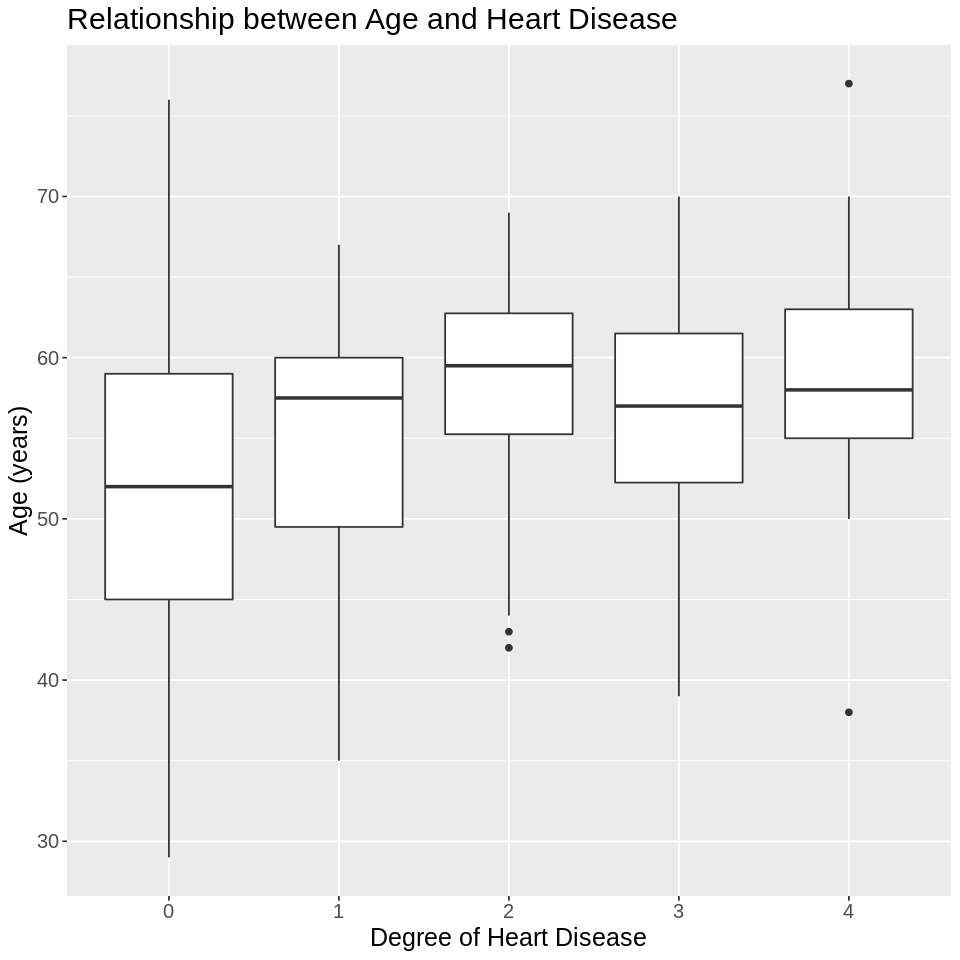

In [81]:
options(repr.plot.height = 8, repr.plot.width = 8)
age_plot <- cleveland_training |>
    ggplot(aes(y = age, x = num)) +
    geom_boxplot() +
    labs(x = "Degree of Heart Disease",
         y = "Age (years)") +
    theme(text = element_text(size = 15)) +
    ggtitle("Relationship between Age and Heart Disease")
age_plot

Based on the results from our histogram, it shows that there is no distinct relationship between age and num.

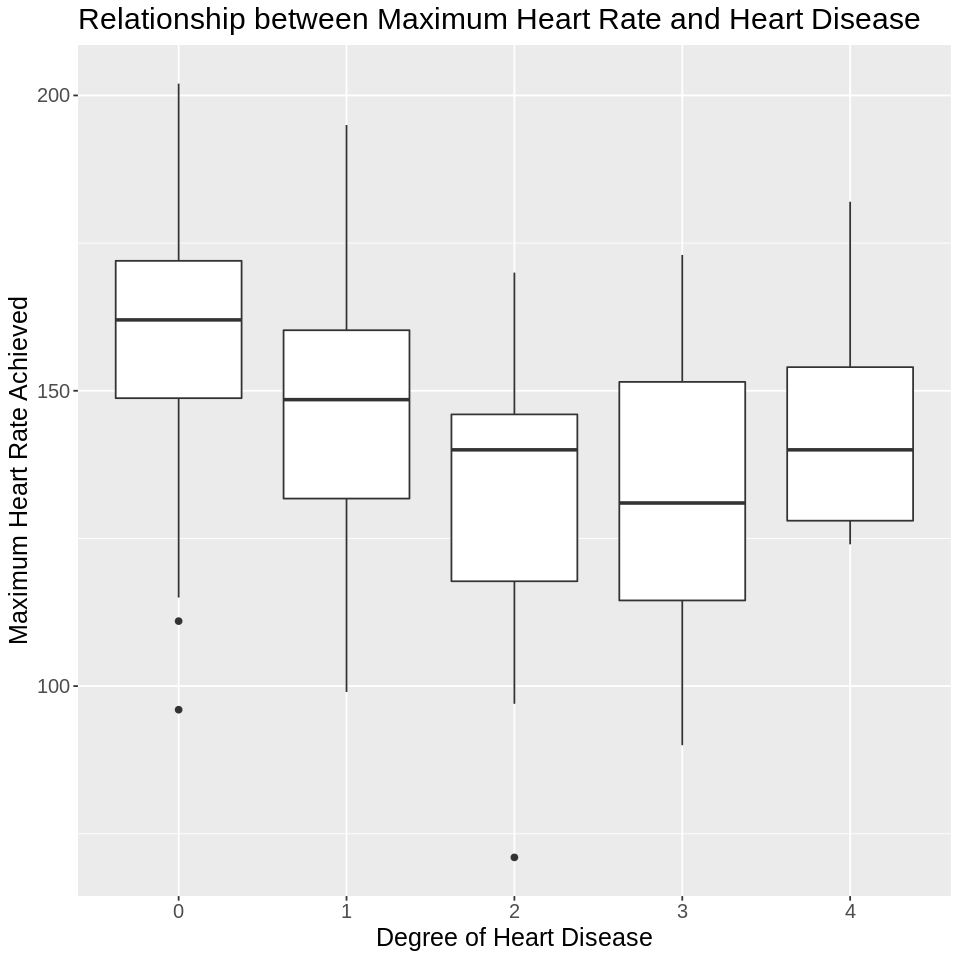

In [83]:
thalach_plot2 <- cleveland_training |>
    ggplot(aes(y = thalach, x = num)) +
    geom_boxplot() +
    labs(x = "Degree of Heart Disease",
         y = "Maximum Heart Rate Achieved") +
    theme(text = element_text(size = 15)) +
    ggtitle("Relationship between Maximum Heart Rate and Heart Disease")
thalach_plot2

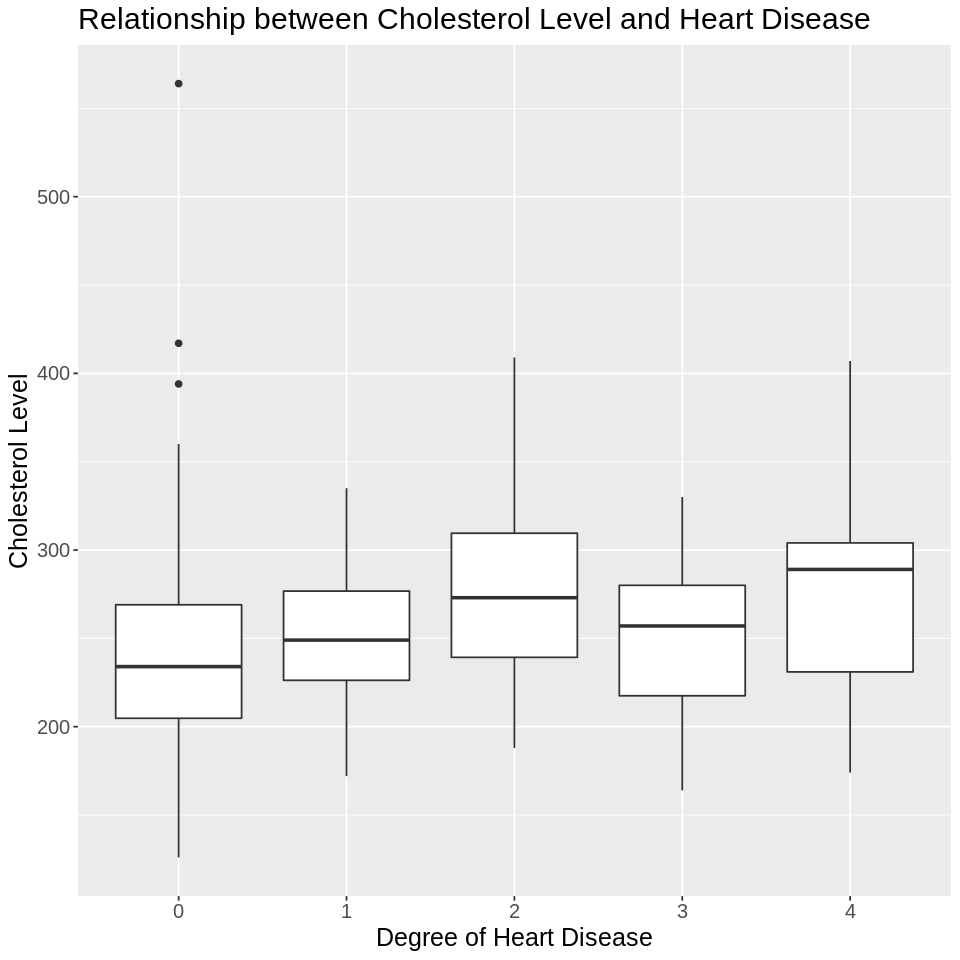

In [84]:
chol_plot <- cleveland_training |>
    ggplot(aes(y = chol, x = num)) +
    geom_boxplot() +
    labs(x = "Degree of Heart Disease",
         y = "Cholesterol Level") +
    theme(text = element_text(size = 15)) +
    ggtitle("Relationship between Cholesterol Level and Heart Disease")
chol_plot

? Explanation for chol plot

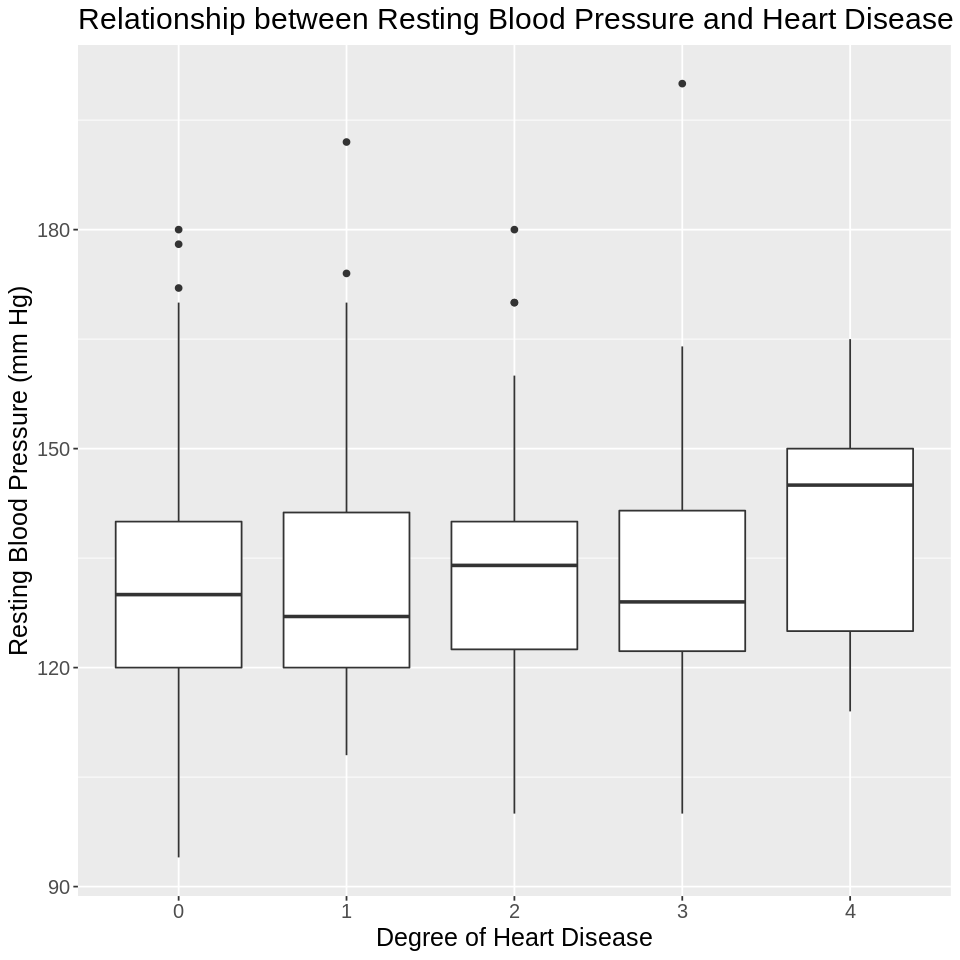

In [85]:
bp_plot <- cleveland_training |>
    ggplot(aes(y = trestbps, x = num)) +
    geom_boxplot() +
    labs(x = "Degree of Heart Disease",
         y = "Resting Blood Pressure (mm Hg)") +
    theme(text = element_text(size = 15)) +
    ggtitle("Relationship between Resting Blood Pressure and Heart Disease")
bp_plot

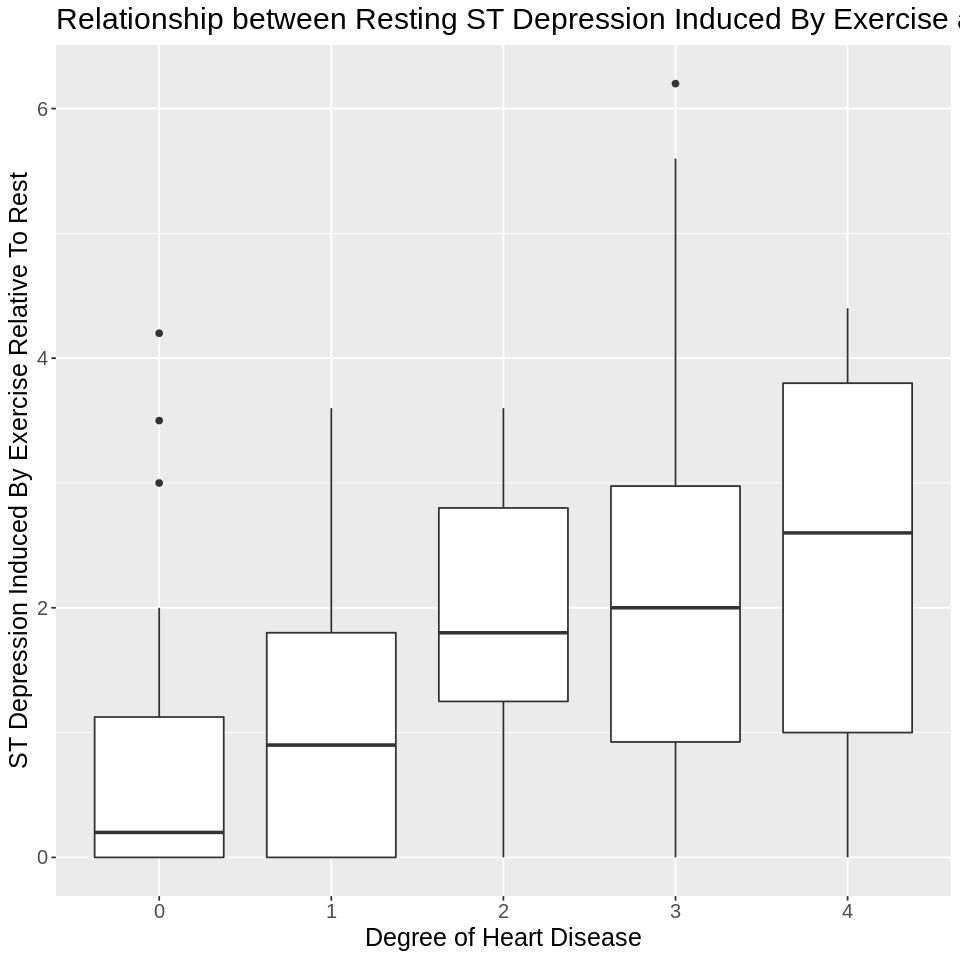

In [86]:
oldpeak_plot <- cleveland_training |>
    ggplot(aes(y = oldpeak, x = num)) +
    geom_boxplot() +
    labs(x = "Degree of Heart Disease",
         y = "ST Depression Induced By Exercise Relative To Rest") +
    theme(text = element_text(size = 15)) +
    ggtitle("Relationship between Resting ST Depression Induced By Exercise and Heart Disease")
oldpeak_plot

# Building the Classification Model #

In [47]:
library(themis)
cleveland_recipe <- recipe(num ~ ., data = cleveland_training) |>
step_upsample(num, over_ratio = 1, skip = FALSE) |>
prep()

upsampled_cleveland <- bake(cleveland_recipe, cleveland_training)

count_upsampled <- upsampled_cleveland|>
                      group_by(num) |>
                        summarize(n= n())
head(upsampled_cleveland)

cleveland_recipe_2 <- recipe(num ~ thalach + oldpeak, data = upsampled_cleveland) |>
step_scale(all_predictors()) |>
step_center(all_predictors())

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0
57,0,4,120,354,0,0,163,1,0.6,1,0,3,0
57,1,4,140,192,0,0,148,0,0.4,2,0,6,0
56,0,2,140,294,0,2,153,0,1.3,2,0,3,0


In [48]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("classification")

In [88]:
cleveland_wkflw <- workflow() |>
    add_recipe(cleveland_recipe_2) |>
    add_model(knn_spec)

In [50]:
set.seed(1)
gridvals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))
vfold_val <- vfold_cv(upsampled_cleveland, v = 5, strata = num)

In [51]:
cleveland_results <- cleveland_wkflw |>
tune_grid(resamples = vfold_val, grid = gridvals) |>
collect_metrics() |>
filter(.metric == "accuracy")
cleveland_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8583333,5,0.01369306,Preprocessor1_Model01
2,accuracy,multiclass,0.8650000,5,0.01379412,Preprocessor1_Model02
3,accuracy,multiclass,0.8433333,5,0.01500000,Preprocessor1_Model03
4,accuracy,multiclass,0.8350000,5,0.01328115,Preprocessor1_Model04
5,accuracy,multiclass,0.7900000,5,0.01522972,Preprocessor1_Model05
6,accuracy,multiclass,0.7633333,5,0.01073675,Preprocessor1_Model06
7,accuracy,multiclass,0.6850000,5,0.01476670,Preprocessor1_Model07
8,accuracy,multiclass,0.6833333,5,0.01020621,Preprocessor1_Model08
9,accuracy,multiclass,0.6450000,5,0.01798919,Preprocessor1_Model09


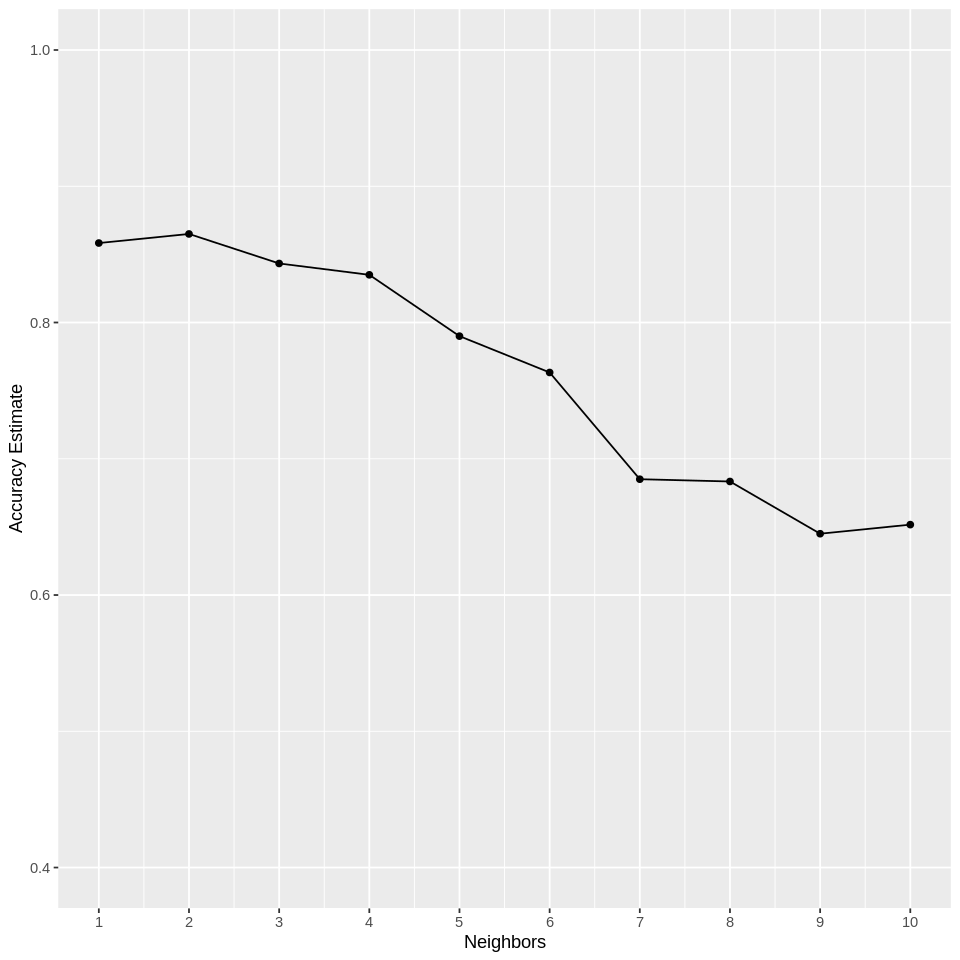

In [52]:
accuracy_versus_k <- ggplot(cleveland_results, aes(x = neighbors, y = mean)) +
geom_point() +
geom_line() +
labs(x = "Neighbors", y = "Accuracy Estimate") +
scale_x_continuous(breaks = seq(1, 10, by = 1)) +  
scale_y_continuous(limits = c(0.4, 1.0))
accuracy_versus_k

In [53]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
set_engine("kknn") |>
set_mode("classification")

cleveland_fit <- workflow() |>
add_recipe(cleveland_recipe_2) |>
add_model(knn_spec) |>
fit(data = upsampled_cleveland)
cleveland_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(2,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1116667
Best kernel: rectangular
Best k: 2

In [75]:
cleveland_test_predictions <- predict(cleveland_fit, cleveland_testing) |>
bind_cols(cleveland_testing)

cleveland_prediction_accuracy <- cleveland_test_predictions |>
metrics(truth = num, estimate = .pred_class) |>
filter(.metric == "accuracy")
cleveland_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.4605263


In [76]:
cleveland_mat <- cleveland_test_predictions |>
conf_mat(truth = num, estimate = .pred_class)
cleveland_mat 

          Truth
Prediction  0  1  2  3  4
         0 28  8  4  4  1
         1  5  3  3  2  0
         2  3  0  2  1  1
         3  2  3  0  2  2
         4  2  0  0  0  0

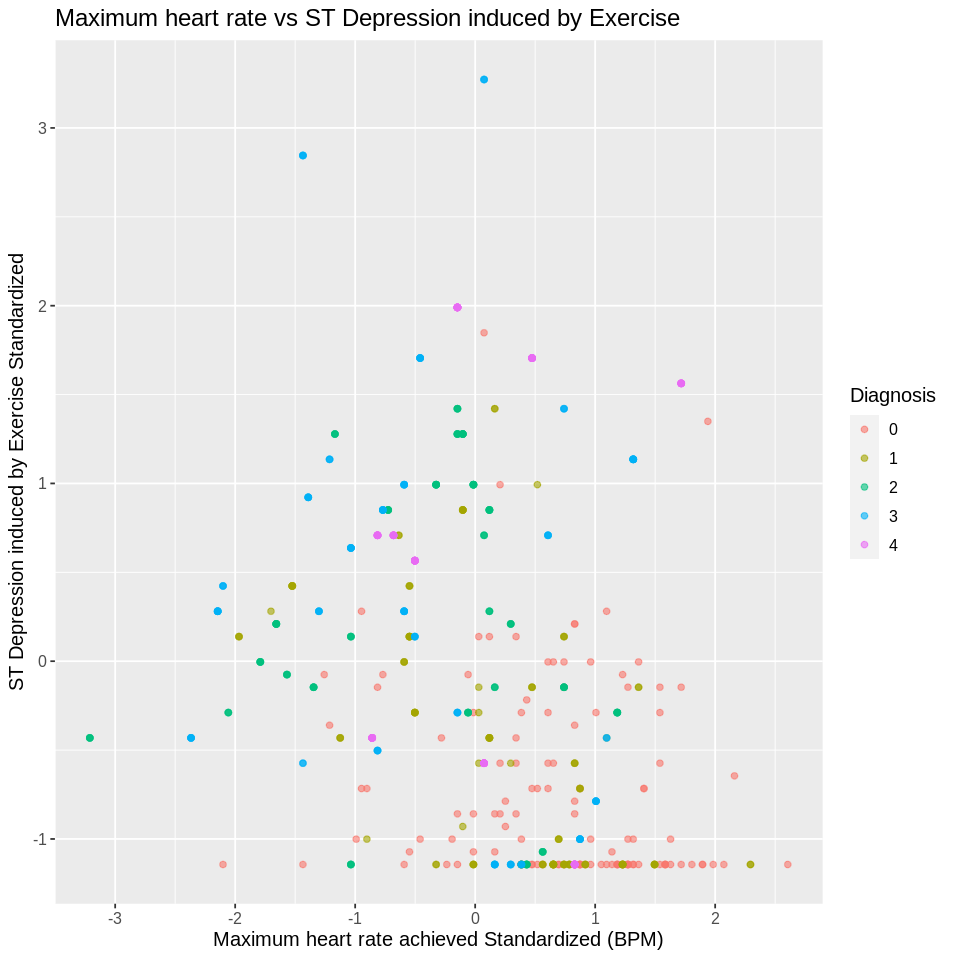

In [70]:
upsampled_cleveland_scaled <- upsampled_cleveland |>
mutate(across(age:thal, scale))

cleveland_plot <- upsampled_cleveland_scaled |>
ggplot(aes(x = thalach, y = oldpeak, color = num)) +
geom_point(alpha = 0.6) +
labs(x = "Maximum heart rate achieved Standardized (BPM)", y = "ST Depression induced by Exercise Standardized", color = "Diagnosis") +
theme(text = element_text(size = 12)) +
ggtitle("Maximum heart rate vs ST Depression induced by Exercise")
cleveland_plot 

# Expected outcomes and significance #
From our research and findings, we expect that lower maximum heart rate (thalach) is a possible indicator/association for heart disease. We hope that our findings can validate other papers. The impact of these findings could influence the population of Cleveland to change certain practices according to our analysis. Future research related to heart disease could go down different paths, such as nutrition or  different lifestyle habits or practices. For example,  focus on different foods that help reduce cholesterol levels, which could potentially reduce heart disease. 

# Variables #
 1. (age) -> age in years
2. (sex) -> sex (1 = male; 0 = female)  
3. (cp) -> cp: chest pain type
4. (trestbps) -> resting blood pressure (in mm Hg on admission to the 
        hospital)
5. (chol) -> serum cholesterol in mg/dl
6. (fbs) -> (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
7. (restecg) -> resting electrocardiographic results
8. (thalach) -> maximum heart rate achieved
9. (exang) -> exercise induced angina 1= yes, 0= no
10. (oldpeak) -> ST depression induced by exercise relative to rest
11. (slope) ->  the slope of the peak exercise ST segment
 Value 1: upsloping
Value 2: flat
Value 3: downsloping
12. (ca) -> number of major vessels (0-3) colored by flourosopy
13. (thal) -> 3= normal, 6= fixed defect, 7= reversible defect
14. (num) -> (the predicted attribute) diagnosis of heart disease
Value 0: < 50% diameter narrowing
Value 1: > 50% diameter narrowing (in any major vessel)
